Notebook para correr local una vez que se exporta el dataframe con detecciones salido de detectron

#### **Importing libraries**

In [1]:
# Miscellaneous
import os
import json
import shutil
import random
from tqdm import tqdm
from PIL import Image
import pandas as pd
import cv2
import supervision as sv
from IPython.display import display, clear_output, Image
import numpy as np
import time
from psutil import virtual_memory
import multiprocessing
from scipy.interpolate import splprep, splev
import math
from typing import Tuple, List, Optional
from shapely.geometry import Point, Polygon

# matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors

import torch
from typing import List, Optional
import logging

logger = logging.getLogger(__name__)
class_names = ['car'] # hard-coded so as not to load and register dataset each time

#### **Funciones auxiliares**

In [3]:
def crop_video_by_time(video_path, start_time, end_time, output_folder):
    """
    Crops a video between the given start and end times and saves it to the output folder.
    Includes a progress bar and a completion message.

    Parameters:
    - video_path: Path to the input video file.
    - start_time: List [mm, ss] representing the start time of the crop.
    - end_time: List [mm, ss] representing the end time of the crop.
    - output_folder: Path to the output folder where the cropped video will be saved.

    Returns:
    - The path to the output cropped video.
    """
    # Convert start and end times to seconds
    start_seconds = start_time[0] * 60 + start_time[1]
    end_seconds = end_time[0] * 60 + end_time[1]

    # Open the video file
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise ValueError(f"Error: Unable to open video {video_path}")

    # Get video properties
    fps = cap.get(cv2.CAP_PROP_FPS)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    duration_seconds = total_frames / fps

    # Validate time inputs
    if start_seconds >= duration_seconds:
        cap.release()
        raise ValueError("Start time is beyond the video duration.")
    if end_seconds > duration_seconds:
        end_seconds = duration_seconds  # Adjust end time to video duration
    if start_seconds >= end_seconds:
        cap.release()
        raise ValueError("Start time must be less than end time.")

    # Calculate frame numbers for start and end
    start_frame = int(start_seconds * fps)
    end_frame = int(end_seconds * fps)

    # Set the starting frame position
    cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)

    # Ensure the output folder exists
    os.makedirs(output_folder, exist_ok=True)

    # Prepare output file path
    video_name = os.path.splitext(os.path.basename(video_path))[0]  # Get the video name without extension
    output_path = os.path.join(output_folder, f"{video_name}_cropped.mp4")

    # Initialize the video writer for output video
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    # Calculate the number of frames to process
    frames_to_process = end_frame - start_frame

    # Initialize tqdm progress bar
    with tqdm(total=frames_to_process, desc='Cropping Video', unit='frame') as pbar:
        current_frame = start_frame
        while current_frame < end_frame:
            ret, frame = cap.read()
            if not ret:
                break  # End of video or read error
            out.write(frame)
            pbar.update(1)
            current_frame += 1

    # Release resources
    cap.release()
    out.release()

    # Print completion message
    print(f"Video successfully cropped and saved at: {output_path}")

    return output_path

In [4]:
def get_first_frame(video_path):
    # Get the first frame from the video
    cap = cv2.VideoCapture(video_path)
    ret, frame = cap.read()
    if not ret:
        print("Error: Unable to read video")
        return None
    cap.release()
    return frame

def manually_input_lines():
    print("Enter the coordinates for the lines in the format x1 y1 x2 y2 (one line per input). Type 'done' when finished.")
    lines_points = []
    counter = 1
    while True:
        user_input = input(f"Enter coordinates for Line {counter}: ")
        if user_input.lower() == 'done':
            break
        try:
            x1, y1, x2, y2 = map(int, user_input.split())
            lines_points.append((x1, y1, x2, y2))
            counter += 1
        except ValueError:
            print("Invalid input. Please enter four integers separated by spaces.")
    return lines_points

def draw_lines_on_frame(frame, lines_points, lw=5, fontsize=10):
    # Determine ideal line weight and fontsize
    if frame is not None:
      height, width, channels = frame.shape
      font_size = int(height/432)
      line_width = int(font_size/2)
    else:
      font_size = fontsize
      line_width = lw
      print("No frame to process.")

    # Draw lines on the frame according to the input coordinates
    for i, (x1, y1, x2, y2) in enumerate(lines_points):
        cv2.line(frame, (int(x1), int(y1)), (int(x2), int(y2)), (255, 255, 255), int(line_width))
        cv2.putText(frame, f'Line {str(i+1)}', (int((x1+x2)/2), int((y1+y2)/2)), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 255, 255), int(font_size), cv2.LINE_AA)
    return frame

def show_image_with_matplotlib(image, title="Image", figsize=(10,10)):
    # Convert BGR image to RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=figsize)
    plt.imshow(image_rgb)
    plt.title(title)
    plt.axis('on')
    plt.show()

def draw_lines_on_video(video_path, lw=5, fontsize=10):
  while True:
    # Get the first frame from the video and show it with axes displayed
    first_frame = get_first_frame(video_path)
    show_image_with_matplotlib(first_frame, title="First frame")
    clear_output(wait=True)
    display(show_image_with_matplotlib(first_frame, title="First Frame"))

    # Input line coordinates
    lines_points = manually_input_lines()

    # Draw lines and show image
    frame_with_lines = draw_lines_on_frame(first_frame.copy(), lines_points, lw, fontsize)

    # Display the frame with the drawn lines
    clear_output(wait=True)
    show_image_with_matplotlib(frame_with_lines, title="First frame with lines")
    time.sleep(3)

    user_input = input('Confirm drawn lines (yes/no): ').strip().lower()
    if user_input == 'yes':
      for n,lp in enumerate(lines_points):
        print(f'Coordinates for Line {n+1}: ({lp[0]},{lp[1]}) --> ({lp[2]},{lp[3]})')
      return lines_points, frame_with_lines

def define_trajectories():
    print("Enter the line numbers for each trajectory in the format n n n n (one line per trajectory). Type 'done' when finished.")
    trajectories = []
    counter = 1
    while True:
        user_input = input(f"Enter line numbers for Trajectory t{counter}: ")
        if user_input.lower() == 'done':
            break
        else:
            try:
                line_numbers = list(map(int, user_input.split()))
                trajectories.append(line_numbers)
                counter += 1
            except ValueError:
                print("Invalid input. Please enter integers separated by spaces.")

    for n,t in enumerate(trajectories):
      print(f'Lines for Trajectory t{n+1}:', t)

    return trajectories

# Generate a custom color palette different from DEFAULT
def get_n_colors(n):
    cmap = cm.get_cmap('tab20', n)  # 'tab20' is a colormap with up to 20 colors
    colors = [cmap(i) for i in range(n)]
    colors_hex = [mcolors.to_hex(rgba) for rgba in colors]
    palette = sv.ColorPalette.from_hex(colors_hex)
    return palette

##  NO USADA PORQUE LAS CURVAS PUEDEN SALIR MEDIO MAL
def draw_curve_with_arrow(frame, points, color=(255, 0, 0), thickness=10):
    # Convert points to a format suitable for splprep
    points = np.array(points, dtype=np.float32)
    x = points[:, 0]
    y = points[:, 1]

    # Create a spline representation of the curve
    tck, u = splprep([x, y], s=0)
    u_new = np.linspace(u.min(), u.max(), num=1000, endpoint=True)
    x_new, y_new = splev(u_new, tck, der=0)

    # Draw the curve on the frame
    for i in range(len(x_new) - 1):
        pt1 = (int(x_new[i]), int(y_new[i]))
        pt2 = (int(x_new[i+1]), int(y_new[i+1]))
        cv2.line(frame, pt1, pt2, color, thickness)

    # Draw an arrow at the end of the spline
    pt_end = (int(x_new[-1]), int(y_new[-1]))
    pt_before_end = (int(x_new[-2]), int(y_new[-2]))
    cv2.arrowedLine(frame, pt_before_end, pt_end, color, thickness, tipLength=0.1)

    return frame

def draw_text_with_background(frame, text, position, font, font_scale, font_thickness, text_color, background_color):
    """Draw text with a background on the frame."""
    text_size = cv2.getTextSize(text, font, int(font_scale), int(font_thickness))[0]
    text_x, text_y = position
    box_coords = ((text_x, text_y - text_size[1]), (text_x + text_size[0], text_y + int(text_size[1] * 0.3)))
    cv2.rectangle(frame, box_coords[0], box_coords[1], background_color, cv2.FILLED)
    cv2.putText(frame, text, (text_x, text_y), font, max(int(font_scale),1), text_color, max(int(font_thickness),1), cv2.LINE_AA)

def draw_trajectory(frame, points, text, color=(255, 0, 0), thickness=10, fill_single_point=True, tipLength=0.1):
    # Determine ideal line weight and fontsize
    if frame is not None:
      height, width, channels = frame.shape
      th = height/216
      tip_length = th/100
      font_thickness = max(int(height/720),2)
      font_scale = max(int(font_thickness/2),1)
    else:
      th = thickness
      tip_length = tipLength
      font_thickness = 3
      font_scale = 1.5
      print("No frame to process. DRAW TRAJECTORY")

    if len(points) == 1:
        # Draw a single point
        pt = (int(points[0][0]), int(points[0][1]))
        circle_thickness = -1 if fill_single_point else th
        cv2.circle(frame, pt, int(th*1.5), color, circle_thickness)  # Draw the point
        # Add text next to the point
        draw_text_with_background(frame, text, (pt[0] + 10, pt[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, font_scale, font_thickness, color, (0, 0, 0))
    else:
        # Draw the trajectory as a succession of small line segments
        for i in range(len(points) - 1):
            pt1 = (int(points[i][0]), int(points[i][1]))
            pt2 = (int(points[i + 1][0]), int(points[i + 1][1]))
            cv2.line(frame, pt1, pt2, color, int(th))

        # Draw an arrow at the end of the trajectory
        pt_end = (int(points[-1][0]), int(points[-1][1]))
        pt_before_end = (int(points[-2][0]), int(points[-2][1]))
        cv2.arrowedLine(frame, pt_before_end, pt_end, color, int(th), tipLength=tip_length)

        # Add text next to the end point
        draw_text_with_background(frame, text, (pt_end[0] + 10, pt_end[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, font_scale, font_thickness, color, (0, 0, 0))

    return frame

def get_fps(video_path):
    # Open the video file
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error: Could not open video {video_path}")
        return

    # Get the frames per second (fps)
    fps = cap.get(cv2.CAP_PROP_FPS)
    # Release the video capture object
    cap.release()

    return fps

def add_legend(frame, legend_items, start_x=10, start_y=10, box_size=50, gap=10, font_scale=1.5, font_thickness=3):
    # Determine ideal line weight and fontsize
    if frame is not None:
      height, width, channels = frame.shape
      start_x = int(height/216)
      start_y = int(height/216)
      box_size = int(start_x*5)
      gap = int(height/216)
      font_thickness = max(int(height/720),2)
      font_scale = max(int(font_thickness/2),1)
    else:
      start_x = start_x
      start_y = start_y
      box_size = box_size
      gap = gap
      font_thickness = font_thickness
      font_scale = font_scale
      print("No frame to process.")

    for i, (label, color) in enumerate(legend_items):
      top_left = (start_x, start_y + i * (box_size + gap))
      bottom_right = (top_left[0] + box_size, top_left[1] + box_size)
      cv2.rectangle(frame, top_left, bottom_right, color, -1)  # Draw filled rectangle
      cv2.putText(frame, label, (top_left[0] + box_size + gap, bottom_right[1] - gap),
          cv2.FONT_HERSHEY_SIMPLEX, font_scale, color, font_thickness, cv2.LINE_AA)  # Add label

    return frame

  # Custom encoder to handle numpy types for json dump
class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()  # Convert numpy arrays to lists
        return super(NumpyEncoder, self).default(obj)

def sv_detections_to_deepsort_inputs(sv_detections):
    """
    Converts sv.Detections object to DeepSORT inputs.

    Parameters:
    - sv_detections: sv.Detections object

    Returns:
    - bbox_xywh: numpy array of shape (N, 4), bounding boxes in [center_x, center_y, width, height]
    - confidences: numpy array of shape (N,), confidence scores
    - class_ids: numpy array of shape (N,), class IDs (or None if not available)
    """
    # Extract bounding boxes in [x_min, y_min, x_max, y_max] format
    xyxy = sv_detections.xyxy  # shape (N, 4)

    # Convert bounding boxes to [center_x, center_y, width, height]
    x_min = xyxy[:, 0]
    y_min = xyxy[:, 1]
    x_max = xyxy[:, 2]
    y_max = xyxy[:, 3]

    widths = x_max - x_min
    heights = y_max - y_min
    center_x = x_min + widths / 2.0
    center_y = y_min + heights / 2.0

    bbox_xywh = np.stack([center_x, center_y, widths, heights], axis=1)

    # Extract confidence scores
    confidences = sv_detections.confidence  # shape (N,)

    # Extract class IDs if available
    class_ids = getattr(sv_detections, 'class_id', None)

    return bbox_xywh, confidences, class_ids

def deepsort_outputs_to_sv_detections(outputs):
    """
    Converts DeepSORT outputs to sv.Detections object.

    Parameters:
    - outputs: numpy array of shape (M, 5), where each row is [x_min, y_min, x_max, y_max, track_id]

    Returns:
    - sv_detections: sv.Detections object with tracker IDs
    """
    if len(outputs) == 0:
        # Return an empty sv.Detections object if there are no outputs
        return sv.Detections(
            xyxy=np.empty((0, 4)),
            confidence=np.empty((0,)),
            class_id=np.empty((0,)),
            tracker_id=np.empty((0,))
        )

    # Extract bounding boxes and tracker IDs
    outputs = np.array(outputs)
    xyxy = outputs[:, 0:4]  # shape (M, 4)
    tracker_ids = outputs[:, 5].astype(int)  # shape (M,)

    # Since DeepSORT does not output confidence scores or class IDs,
    # we can set them to None or default values
    confidences = np.full(len(xyxy), np.nan)
    class_ids = np.full(len(xyxy), 0) # hard coded because I only have one class ID

    # Create sv.Detections object
    sv_detections = sv.Detections(
        xyxy=xyxy,
        confidence=confidences,
        class_id=class_ids,
        tracker_id=tracker_ids
    )
    return sv_detections

def interpolate_missing_detections(df, max_gap=10):
    """
    Interpolates missing detections for each tracker within a maximum gap using linear interpolation.

    Parameters:
    - df (DataFrame): Tracking data with columns ['frame', 'tracker_id', 'x_min', 'y_min', 'x_max', 'y_max']
    - max_gap (int): Maximum number of consecutive missing frames to interpolate

    Returns:
    - df_filled (DataFrame): Tracking data with interpolated detections
    """
    df_filled = pd.DataFrame()
    for tracker_id, group in tqdm(df.groupby('tracker_id'), desc='Interpolating detections between frames',):
        group = group.sort_values('frame')
        frames = group['frame'].values
        bboxes = group[['x_min', 'y_min', 'x_max', 'y_max']].values
        class_ids = group['class_id'].values
        confidences = group['confidence'].values

        # Identify all frames in the track
        all_frames = range(frames[0], frames[-1] + 1)
        existing_frames = set(frames)
        missing_frames = [f for f in all_frames if f not in existing_frames]

        # Find consecutive missing frames
        gaps = []
        current_gap = []
        for f in missing_frames:
            if not current_gap or f == current_gap[-1] + 1:
                current_gap.append(f)
            else:
                gaps.append(current_gap)
                current_gap = [f]
        if current_gap:
            gaps.append(current_gap)

        # Collect new interpolated rows
        new_rows = []

        for gap in gaps:
            if len(gap) > max_gap:
                continue  # Skip large gaps

            start_frame = gap[0] - 1
            end_frame = gap[-1] + 1

            if start_frame < frames[0] or end_frame > frames[-1]:
                continue  # Cannot interpolate without both ends

            start_bbox = group[group['frame'] == start_frame][['x_min', 'y_min', 'x_max', 'y_max']].values[0]
            end_bbox = group[group['frame'] == end_frame][['x_min', 'y_min', 'x_max', 'y_max']].values[0]

            num_missing = len(gap)
            for i, f in enumerate(gap):
                alpha = (i + 1) / (num_missing + 1)
                interp_bbox = start_bbox + alpha * (end_bbox - start_bbox)
                class_id = group[group['frame'] == start_frame]['class_id'].values[0] # Assign class id from start frame
                confidence = min(group[group['frame'] == start_frame]['confidence'].values[0], group[group['frame'] == end_frame]['confidence'].values[0]) # Min confidence
                tracker_id = group[group['frame'] == start_frame]['tracker_id'].values[0]
                group[group['frame'] == end_frame]
                new_row = {
                    'frame': f,
                    'tracker_id': tracker_id,
                    'class_id': class_id,
                    'confidence': class_id,
                    'x_min': interp_bbox[0],
                    'y_min': interp_bbox[1],
                    'x_max': interp_bbox[2],
                    'y_max': interp_bbox[3],
                }
                new_rows.append(new_row)

        # Create a DataFrame from new_rows and concatenate
        if new_rows:
            df_new = pd.DataFrame(new_rows)
            df_filled = pd.concat([df_filled, df_new], ignore_index=True)

        # Concatenate the original detections
        df_filled = pd.concat([df_filled, group], ignore_index=True)

    # Sort by frame and tracker_id
    df_filled = df_filled.sort_values(['frame', 'tracker_id']).reset_index(drop=True)
    return df_filled


def df_to_detections_per_frame(df):
    """
    Converts a DataFrame of tracking data to a list of sv.Detections per frame.

    Parameters:
    - df (DataFrame): Tracking data with columns ['frame', 'tracker_id', 'x_min', 'y_min', 'x_max', 'y_max']

    Returns:
    - detections_per_frame (list): List where each element is an sv.Detections object for a frame
    """
    max_frame = df['frame'].max()
    detections_per_frame = []

    for frame_num in range(max_frame + 1):
        frame_dets = df[df['frame'] == frame_num]
        if frame_dets.empty:
            detections_per_frame.append(sv.Detections.empty())
            continue

        xyxy = frame_dets[['x_min', 'y_min', 'x_max', 'y_max']].values
        confidence = frame_dets['confidence'].values
        class_id = frame_dets['class_id'].values
        tracker_id = frame_dets['tracker_id'].values

        detections = sv.Detections(
            xyxy=xyxy,
            confidence=confidence,
            class_id=class_id,
            tracker_id=tracker_id
        )
        detections_per_frame.append(detections)

    return detections_per_frame


def get_frame(video_path, frame_num):
    cap = cv2.VideoCapture(video_path)

    # Check if the video was successfully opened
    if not cap.isOpened():
        print(f"Error: Unable to open video {video_path}")
        return None

    # Set the position to the specified frame number
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num)

    # Read frame and release video capture object
    ret, frame = cap.read()
    cap.release()

    if not ret:
        print(f"Error: Unable to retrieve frame number {frame_num}")
        return None
    return frame


def plot_surface_on_frame(surface_polygon, frame, color=(0, 0, 255), thickness=2, show=True, figsize=(10,10)):
    """
    Plots the given surface polygon on the provided video frame and displays it using matplotlib.

    Parameters:
    surface_polygon: np.array of shape (3, 2)
        An array containing the three points [lost_center, point_cw, point_acw].
    frame: np.array
        The frame/image where the polygon will be drawn.
    color: tuple, optional (default=(0, 0, 255))
        The color of the polygon in BGR format (default is red).
    thickness: int, optional (default=2)
        The thickness of the polygon edges.
    show: bool, optional (default=True)
        Whether to display the frame using matplotlib.

    Returns:
    frame_with_polygon: np.array
        The frame with the drawn polygon.
    """
    # Convert Shapely polygon to a NumPy array of integer coordinates for OpenCV
    surface_polygon_np = np.array(surface_polygon.exterior.coords).astype(np.int32)

    # Draw the polygon by connecting the three points
    # Close the polygon by repeating the first point at the end
    cv2.polylines(frame, [surface_polygon_np], isClosed=True, color=color, thickness=thickness)

    # Draw circles at each point for better visualization
    for point in surface_polygon_np:
        cv2.circle(frame, tuple(point), radius=5, color=(0, 255, 0), thickness=-1)  # Green circles

    # Add text labels to the points
    labels = ['Lost Center', 'CW Point', 'ACW Point']
    for label, point in zip(labels, surface_polygon_np):
        cv2.putText(frame, label, tuple(point), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2, cv2.LINE_AA)

    # Display the image using matplotlib if show=True
    if show:
        # Convert the frame from BGR to RGB for proper visualization in matplotlib
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        plt.figure(figsize=figsize)
        plt.imshow(frame_rgb)
        plt.title("Surface Polygon on Frame")
        plt.axis("off")  # Hide axis for better visualization
        plt.show()

    return frame

def plot_search_surface(frame_num, front_buffer, distance, frame_width, frame_height, df, back_buffer, video_path, figsize=(10,10), angle=45, use_circular_surface=False):
    frame = get_frame(video_path=video_path, frame_num=frame_num)

    lost_ids, created_ids = find_lost_and_created_tracker_ids(frame1_num=frame_num,
                                                              front_buffer=front_buffer,
                                                              back_buffer=back_buffer,
                                                              distance=distance,
                                                              frame_width=frame_width,
                                                              frame_height=frame_height,
                                                              df_filled=df)

    surface_polygons = []
    if lost_ids:
        for lost_id in lost_ids:
            direction_vector, speed = calculate_direction_and_speed(lost_id=lost_id,
                                                                    df_filled=df,
                                                                    frame_num=frame_num,
                                                                    buffer=30)

            max_displacement = max(speed,2.0) * 90

            # Step 2: Get the last known position of the lost_id
            last_det = df[
                (df['tracker_id'] == lost_id) &
                (df['frame'] == frame_num)
            ]

            last_det = last_det.iloc[0]
            lost_center_x = (last_det['x_min'] + last_det['x_max']) / 2.0
            lost_center_y = (last_det['y_min'] + last_det['y_max']) / 2.0
            lost_center = np.array([lost_center_x, lost_center_y])

            # Step 4: Define the search surface by rotating the line
            # Convert angle to radians
            angle_rad = math.radians(angle)

            # Rotation matrices
            rotation_clockwise = np.array([
                [math.cos(angle_rad), math.sin(angle_rad)],
                [-math.sin(angle_rad), math.cos(angle_rad)]
            ])

            rotation_anticlockwise = np.array([
                [math.cos(angle_rad), -math.sin(angle_rad)],
                [math.sin(angle_rad), math.cos(angle_rad)]
            ])

            # Rotate the direction vector
            rotated_vector_cw = rotation_clockwise @ direction_vector
            rotated_vector_acw = rotation_anticlockwise @ direction_vector

            # Define two points to create the arch surface
            point_cw = lost_center + rotated_vector_cw * max_displacement
            point_acw = lost_center + rotated_vector_acw * max_displacement


            # Create a polygon (triangle) defining the desired surface
            # Points: lost_center, point_cw, point_acw
            # This forms a wedge-shaped area
            surface_polygon = Polygon([
                (lost_center[0], lost_center[1]),
                (point_cw[0], point_cw[1]),
                (point_acw[0], point_acw[1])
            ])

            # Step 5: Define the circular surface if enabled
            if use_circular_surface:
                # Create a circle centered at lost_center with radius = max_displacement
                surface_circle = Point(lost_center).buffer(max_displacement)
                surface_polygons.append(surface_circle)
            else:
                surface_circle = None
                surface_polygons.append(surface_polygon)

        i = 0
        for surface_polygon in surface_polygons:
            if i == len(surface_polygons) - 1:
                plot_surface_on_frame(frame=frame, surface_polygon=surface_polygon, show=True, figsize=figsize)
            else:
                plot_surface_on_frame(frame=frame, surface_polygon=surface_polygon, show=False, figsize=figsize)
                i += 1

        return direction_vector, speed
    else:
       print(f'No lost IDs in frame {frame_num}')

def find_lost_and_created_tracker_ids(frame1_num, front_buffer, distance, frame_width, frame_height, df_filled, back_buffer):
    """
    Identifies tracker IDs that are lost between frame1 and frame2,
    and tracker IDs that are newly created in frame2.

    Parameters:
    - frame1_num (int): Frame number of the source frame.
    - frame2_num (int): Frame number of the target frame.
    - distance (float): Minimum distance from frame edges to consider.
    - frame_width (int): Width of the frame in pixels.
    - frame_height (int): Height of the frame in pixels.
    - df_filled (pd.DataFrame): DataFrame with tracking data.

    Returns:
    - lost_ids (List[int]): List of tracker IDs that are lost unexpectedly.
    - created_ids (List[int]): List of tracker IDs that are newly created unexpectedly.
    """
    # Filter detections for frame1 and frame2
    frame1_dets = df_filled[df_filled['frame'] == frame1_num]
    frame2_dets = df_filled[(df_filled['frame'] > frame1_num) & (df_filled['frame'] <= frame1_num + front_buffer)]

    frame3_dets = df_filled[df_filled['frame'] == max(frame1_num - back_buffer,0)]
    frame4_dets = df_filled[(df_filled['frame'] > max(frame1_num - back_buffer,0)) & (df_filled['frame'] <= frame1_num + front_buffer)] # Miro 5 frames para atrás por posible simultaneidad de lost_id y created_id

    # Extract tracker IDs
    frame1_ids = set(frame1_dets['tracker_id'].unique())
    frame2_ids = set(frame2_dets['tracker_id'].unique())
    frame3_ids = set(frame3_dets['tracker_id'].unique())
    frame4_ids = set(frame4_dets['tracker_id'].unique())

    # Identify lost_ids: IDs present in frame1 but missing following frames
    missing_ids = frame1_ids - frame2_ids

    # Identify created_ids: IDs present in following frames but not in frame1
    #new_ids = frame2_ids - frame1_ids
    new_ids = frame4_ids - frame3_ids

    # Initialize lists to hold lost and created tracker IDs
    lost_ids = []
    created_ids = []

    # Helper function to check if a bounding box center is sufficiently inside the frame
    def is_center_within(bb, dist, width, height):
        x_min, y_min, x_max, y_max = bb
        center_x = (x_min + x_max) / 2.0
        center_y = (y_min + y_max) / 2.0
        return (center_x > dist and
                center_x < (width - dist) and
                center_y > dist and
                center_y < (height - dist))

    # Process missing_ids to find lost_ids
    for tracker_id in missing_ids:
        # Get the bounding box for this tracker in frame1
        det = frame1_dets[frame1_dets['tracker_id'] == tracker_id].iloc[0]
        bb = det[['x_min', 'y_min', 'x_max', 'y_max']].values
        if is_center_within(bb, distance, frame_width, frame_height):
            # This tracker was lost but should still be within the frame
            lost_ids.append(tracker_id)

    # Process new_ids to find created_ids
    for tracker_id in new_ids:
        # Get the bounding box for this tracker in frame4 (frame2)
        det = frame4_dets[frame4_dets['tracker_id'] == tracker_id].iloc[0] # Se toma la primera detección dentro del buffer (frame2)
        bb = det[['x_min', 'y_min', 'x_max', 'y_max']].values
        if is_center_within(bb, distance, frame_width, frame_height):
            # This tracker was newly created but should have been tracked already
            created_ids.append(tracker_id)

    lost_ids = sorted(lost_ids)
    created_ids = sorted(created_ids)

    return lost_ids, created_ids


def calculate_direction_and_speed(
    lost_id: int,
    df_filled: pd.DataFrame,
    frame_num: int,
    buffer: int
) -> Tuple[np.ndarray, float]:
    """
    Calculates the direction vector and average speed for a lost tracker ID based on its recent trajectory.

    Parameters:
    - lost_id (int): The tracker ID that has been lost.
    - df_filled (pd.DataFrame): DataFrame containing tracking data with interpolated detections.
    - frame_num (int): The frame number where the tracker was lost.
    - buffer (int): Number of frames to look back for calculating direction and speed.

    Returns:
    - direction_vector (np.ndarray): Normalized 2D direction vector [dx, dy].
    - average_speed (float): Average speed in pixels per frame.

    Raises:
    - ValueError: If there are insufficient detections within the buffer to perform calculations.
    """
    # Define the range of frames to look back
    start_frame = max(frame_num - buffer, 0)
    end_frame = frame_num # Exclude the lost frame

    # Filter detections for the lost_id within the buffer frames
    recent_dets = df_filled[
        (df_filled['tracker_id'] == lost_id) &
        (df_filled['frame'] >= start_frame) &
        (df_filled['frame'] <= end_frame)
    ].sort_values('frame')

    # Check if there are enough detections to perform calculations
    if recent_dets.shape[0] < 2:
        raise ValueError(f"Insufficient detections for tracker ID {lost_id} within the buffer.")

    # Extract the center coordinates of the bounding boxes
    centers = recent_dets[['x_min', 'y_min', 'x_max', 'y_max']].values
    centers_x = (centers[:, 0] + centers[:, 2]) / 2.0
    centers_y = (centers[:, 1] + centers[:, 3]) / 2.0

    # Prepare the data for least squares fitting (linear regression)
    A = np.vstack([centers_x, np.ones(len(centers_x))]).T
    slope, intercept = np.linalg.lstsq(A, centers_y, rcond=None)[0]

    # Calculate direction vector based on the slope
    # The slope (m) corresponds to dy/dx; thus, direction vector is [1, m]
    direction_vector = np.array([1, slope])
    norm = np.linalg.norm(direction_vector)
    if norm == 0:
        raise ValueError(f"Zero direction vector for tracker ID {lost_id}.")
    direction_vector /= norm  # Normalize the vector

    # Calculate displacement vector
    displacement_vector = np.array([centers_x[-1] - centers_x[0], centers_y[-1] - centers_y[0]])

    # Determine sign of direction vector
    dot_product = np.dot(direction_vector, displacement_vector)
    if dot_product < 0:
        direction_vector = -direction_vector

    total_displacement = np.linalg.norm([
        centers_x[-1] - centers_x[0],
        centers_y[-1] - centers_y[0]
    ])

    # Calculate the number of frames moved
    num_frames = recent_dets['frame'].iloc[-1] - recent_dets['frame'].iloc[0]

    # Avoid division by zero
    if num_frames == 0:
        raise ValueError(f"No frame difference for tracker ID {lost_id}.")

    # Calculate average speed
    average_speed = total_displacement / num_frames

    return direction_vector, average_speed


def reassign_lost_id(
    lost_id: int,
    direction_vector: np.ndarray,
    speed: float,
    df_filled: pd.DataFrame,
    created_ids: List[int],
    frame_num: int,
    buffer: int=30,
    angle: float = 45, # Default rotation angle in degrees
    use_circular_surface=False
) -> Optional[int]:
    """
    Reassigns a lost tracker ID to the closest created ID within a defined search surface.

    Parameters:
    - lost_id (int): The tracker ID that has been lost.
    - direction_vector (np.ndarray): Normalized 2D direction vector [dx, dy].
    - speed (float): Average speed in pixels per frame.
    - buffer (int): Number of frames ahead to search for potential reassignment.
    - df_filled (pd.DataFrame): DataFrame containing tracking data with interpolated detections.
    - created_ids (List[int]): List of newly created tracker IDs in the buffer frames.
    - frame_num (int): The frame number where the lost_id was last present.
    - frame_width (int): Width of the video frame in pixels.
    - frame_height (int): Height of the video frame in pixels.
    - angle (float): Angle in degrees to rotate the displacement line for defining the search surface.

    Returns:
    - reassigned_id (int or None): The created ID reassigned to the lost_id, or None if no match found.
    """
    # Step 1: Calculate maximum displacement
    max_displacement = max(speed,2.0) * buffer

    # Step 2: Get the last known position of the lost_id
    last_det = df_filled[
        (df_filled['tracker_id'] == lost_id) &
        (df_filled['frame'] == frame_num)
    ]

    if last_det.empty:
        print(f"No detection found for lost_id {lost_id} in frame {frame_num}.")
        return df_filled

    last_det = last_det.iloc[0]
    lost_center_x = (last_det['x_min'] + last_det['x_max']) / 2.0
    lost_center_y = (last_det['y_min'] + last_det['y_max']) / 2.0
    lost_center = np.array([lost_center_x, lost_center_y])

    # Step 3: Calculate the end point based on direction vector and max displacement
    end_point = lost_center + direction_vector * max_displacement

    # Step 4: Define the search surface by rotating the line
    # Convert angle to radians
    angle_rad = math.radians(angle)

    # Rotation matrices
    rotation_clockwise = np.array([
        [math.cos(angle_rad), math.sin(angle_rad)],
        [-math.sin(angle_rad), math.cos(angle_rad)]
    ])

    rotation_anticlockwise = np.array([
        [math.cos(angle_rad), -math.sin(angle_rad)],
        [math.sin(angle_rad), math.cos(angle_rad)]
    ])

    # Rotate the direction vector
    rotated_vector_cw = rotation_clockwise @ direction_vector
    rotated_vector_acw = rotation_anticlockwise @ direction_vector

    # Define two points to create the arch surface
    point_cw = lost_center + rotated_vector_cw * max_displacement
    point_acw = lost_center + rotated_vector_acw * max_displacement

    # Create a polygon (triangle) defining the desired surface
    # Points: lost_center, point_cw, point_acw
    # This forms a wedge-shaped area
    surface_polygon = Polygon([
        (lost_center[0], lost_center[1]),
        (point_cw[0], point_cw[1]),
        (point_acw[0], point_acw[1])
    ])

    # Step 5: Define the circular surface if enabled
    if use_circular_surface:
        # Create a circle centered at lost_center with radius = max_displacement
        surface_circle = Point(lost_center).buffer(max_displacement)
    else:
        surface_circle = None

    # Step 6: Find created_ids within the desired surface
    eligible_created_ids = []
    for created_id in created_ids:
        created_det = df_filled[
            (df_filled['tracker_id'] == created_id) &
            (df_filled['frame'] > frame_num) &
            (df_filled['frame'] <= frame_num + buffer)
        ]

        if created_det.empty:
            continue  # Skip if no detection found within buffer frames

        # Assuming the first occurrence within buffer
        created_det = created_det.iloc[0]
        created_center_x = (created_det['x_min'] + created_det['x_max']) / 2.0
        created_center_y = (created_det['y_min'] + created_det['y_max']) / 2.0
        created_center = np.array([created_center_x, created_center_y])

        # Check if the created_center is within the polygon surface
        in_polygon = surface_polygon.contains(Point(created_center))

        # Check if the created_center is within the circular surface (if enabled)
        in_circle = False
        if surface_circle:
            in_circle = surface_circle.contains(Point(created_center))

        # Determine if the created_id is eligible based on surface type
        if use_circular_surface:
            if in_circle:
                eligible_created_ids.append((created_id, created_center))
        else:
            if in_polygon:
                eligible_created_ids.append((created_id, created_center))           

    if not eligible_created_ids:
        #print(f"No eligible created IDs found for lost_id {lost_id} in frame {frame_num}.")
        return df_filled

    # Step 7: Select the closest created_id to the lost_id's last center
    min_distance = float('inf')
    reassigned_id = None
    for created_id, created_center in eligible_created_ids:
        distance = np.linalg.norm(created_center - lost_center)
        if distance < min_distance:
            min_distance = distance
            reassigned_id = created_id

    # Step 8: Reassign the tracker_id in df_filled
    if reassigned_id is not None:
        df_filled.loc[df_filled['tracker_id'] == reassigned_id, 'tracker_id'] = lost_id
        #print(f"Reassigned lost_id {lost_id} to created_id {reassigned_id} in frame {frame_num}.")
    else:
        print(f"No reassignment made for lost_id {lost_id}.")

    return df_filled

def point_in_polygon(point: np.ndarray, polygon: np.ndarray) -> bool:
    """
    Determines if a point is inside a polygon using the ray casting algorithm.

    Parameters:
    - point (np.ndarray): The point [x, y] to check.
    - polygon (np.ndarray): An array of polygon vertices [[x1, y1], [x2, y2], ..., [xn, yn]].

    Returns:
    - inside (bool): True if the point is inside the polygon, False otherwise.
    """
    x, y = point
    n = len(polygon)
    inside = False

    px1, py1 = polygon[0]
    for i in range(1, n + 1):
        px2, py2 = polygon[i % n]
        if min(py1, py2) < y <= max(py1, py2):
            if x <= max(px1, px2):
                if py1 != py2:
                    xinters = (y - py1) * (px2 - px1) / (py2 - py1) + px1
                if px1 == px2 or x <= xinters:
                    inside = not inside
        px1, py1 = px2, py2

    return inside

def predict_and_track_on_video(video_path, output_video_path, predictor, lines_points=None, trajectories=None, trace_length=0, bbox_tracked='color',
                               bbox_untracked='blur', annotate_untracked=False, slice_frames=True, classes=class_names, overlap_wh=(0.2, 0.2), slice_wh=(512,512),
                               frame_step=1, json_dump=False, tracker_alg='ByteTrack'):
    '''
    lines_points: tuplas de cuatro valores (x1,y1,x2,y2) que definen las lineas en el video
    trajectories: listas de números enteros [1,2,...,n] conteniendo indices de lineas en lines_points
    slice: Define si hacer deteccion fragmentando la imagen en sectores
    frame_step: Define el paso de frames a procesar. frame_steps=1 procesa todos los frames. frame_steps=2 procesa cada segundo frame, etc.
    '''

    # Draw lines
    if lines_points is None:
      lines_points, frame_with_lines = draw_lines_on_video(video_path)
    else:
      first_frame = get_first_frame(video_path)
      frame_with_lines = draw_lines_on_frame(first_frame.copy(), lines_points)
      show_image_with_matplotlib(frame_with_lines, title="First frame with lines")
      time.sleep(3)
      print("Using provided line points:")
      for n,lp in enumerate(lines_points):
        print(f'Coordinates for Line {n+1}: ({lp[0]},{lp[1]}) --> ({lp[2]},{lp[3]})')

    # Define trajectories
    if trajectories is None:
      trajectories = define_trajectories()
    else:
      print("\nUsing provided trajectories:")
      for n,t in enumerate(trajectories):
        print(f'Lines for Trajectory t{n+1}:', t)

    # Annotator instances
    n = len(trajectories)
    palette = get_n_colors(n) # color palette
    trajectories_dict = {f't{x+1}': {'lines':trajectories[x]} for x in range(n)} # Dictionary to store trajectories and annotators

    # Draw trajectories
    time.sleep(2)
    trajectories_mid_points = []
    for trajectory in trajectories:
      mid_points = [((lines_points[line-1][0] + lines_points[line-1][2])/2, (lines_points[line-1][1] + lines_points[line-1][3])/2) for line in trajectory]
      trajectories_mid_points.append(mid_points)

    frame_with_lines_and_trajectories = frame_with_lines.copy()
    for points in trajectories_mid_points:
      i = trajectories_mid_points.index(points)
      frame_with_lines_and_trajectories = draw_trajectory(frame_with_lines_and_trajectories, points, f't{i+1}', color=palette.colors[i].as_bgr())
      if i == len(trajectories_mid_points)-1:
        show_image_with_matplotlib(frame_with_lines_and_trajectories, title="First frame with trajectories")

    # Classes
    # classes = MetadataCatalog.get(cfg.DATASETS.TEST[0]).thing_classes # Class names (hard coded not to load dataset each time)
    classes = ['car']

    # Font weights and thicknesses for annotators
    h,w,c = get_first_frame(video_path).shape
    ann_th = max(int(h/1080),1)
    txt_scale, txt_th = h/4320, max(int(h/2160),1)

    # Tracked cars
    for x in range(n):
      if bbox_tracked == 'box':
        trajectories_dict[f't{x+1}']['box_ann'] = sv.BoxAnnotator(color=palette.colors[x], thickness=ann_th)
      else:
        trajectories_dict[f't{x+1}']['box_ann'] = sv.ColorAnnotator(color=palette.colors[x])

      if trace_length > 0:
        trajectories_dict[f't{x+1}']['trace_ann'] = sv.TraceAnnotator(trace_length=trace_length, color=palette.colors[x])

      trajectories_dict[f't{x+1}']['label_ann'] = sv.LabelAnnotator(color=palette.colors[x], text_color=sv.Color.from_hex('#000000'), text_scale=txt_scale, text_thickness=txt_th)

    # Untracked cars
    if bbox_untracked == 'box':
      box_annotator_untracked = sv.BoxAnnotator(thickness=ann_th)
    elif bbox_untracked == 'pixel':
      box_annotator_untracked = sv.PixelateAnnotator()
    else:
      box_annotator_untracked = sv.BlurAnnotator()

    if annotate_untracked == True:
      label_annotator_untracked = sv.LabelAnnotator(text_scale=txt_scale, text_thickness=txt_th)

    if trace_length > 0:
      trace_annotator_untracked = sv.TraceAnnotator(trace_length=trace_length)

    # Video info and frame generator
    video_info = sv.VideoInfo.from_video_path(video_path=video_path)
    frame_generator = sv.get_video_frames_generator(source_path=video_path) # for generating frames from video


    # Tracker and smoother
    thresh = predictor.cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST
    smoother = sv.DetectionsSmoother(length=5)
    if tracker_alg == 'DeepSort':
      tracker = DeepSort('deep_sort/deep/checkpoint/ckpt.t7',
                          max_dist=0.2, min_confidence=thresh,
                          nms_max_overlap=1.0, max_iou_distance=0.7,
                          max_age=300, n_init=1, nn_budget=200,
                          use_cuda=True
                          )
    else:
      tracker = sv.ByteTrack(frame_rate=video_info.fps,
                             lost_track_buffer=150,
                             minimum_matching_threshold=0.6,
                             track_activation_threshold=thresh,
                             minimum_consecutive_frames=1,
                             )  # Bytetracker instance. 5 seconds lost_track_buffer
      tracker.reset()  # Reset tracker to reset counts

    # Line counters and Line annotator
    line_counters = []
    for x1,y1,x2,y2 in lines_points:
      line = (sv.Point(x=x1, y=y1), sv.Point(x=x2, y=y2)) # Lines for count in/out vehicle
      line_counter = sv.LineZone(start=line[0], end=line[1], triggering_anchors=[sv.Position.CENTER])
      line_counters.append(line_counter)

    line_annotator = sv.LineZoneAnnotator(thickness=2, text_thickness=2, text_scale= 0.5, custom_in_text='Left to Right', custom_out_text='Right to Left', display_in_count=False, display_out_count=False)
    line_counters_dict = {f'l{x+1}': {'coords':lines_points[x], 'LtoR':[], 'RtoL':[]} for x in range(len(lines_points))} # Dictionary to store ids of crossing vehicles

    # Callback definition function for image slicing
    def callback(image_slice: np.ndarray) -> sv.Detections:
      outputs = predictor(image_slice)
      detections = sv.Detections.from_detectron2(outputs)
      return detections

    tracking_results = [] # List to store every sv.Detection object for interpolation

    # Process all frames and get detections as a list of sv.Detections objects (before creating video)
    for i,frame in tqdm(enumerate(frame_generator), total= video_info.total_frames, desc='Processing frames for first time',):
        if i % frame_step == 0:
            # Getting result from model
            if slice_frames:
            # Image slicer object
              slicer = sv.InferenceSlicer(callback=callback, overlap_wh=overlap_wh, slice_wh=slice_wh, overlap_ratio_wh=None)
              detections = slicer(image=frame)
            else:
              outputs = predictor(frame)
              detections = sv.Detections.from_detectron2(outputs)   # Getting detections

            if tracker_alg == 'DeepSort':
              bbox_xywh, confidences, class_ids = sv_detections_to_deepsort_inputs(detections)
              outputs = tracker.update(bbox_xywh=bbox_xywh, confidences=confidences, classes=class_ids, ori_img=frame)
              detections = deepsort_outputs_to_sv_detections(outputs[0])
            else:
              detections = tracker.update_with_detections(detections)  # Updating detection to ByteTrack

            detections = smoother.update_with_detections(detections)  # Smoothing detections

            # Store tracking results
            for d in range(len(detections)):
                tracking_results.append({
                    'frame': i,
                    'tracker_id': detections[d].tracker_id[0],
                    'class_id': detections[d].class_id[0],
                    'confidence': detections[d].confidence[0],
                    'x_min': detections[d].xyxy[0][0],
                    'y_min': detections[d].xyxy[0][1],
                    'x_max': detections[d].xyxy[0][2],
                    'y_max': detections[d].xyxy[0][3],
                })

    #Interpolate missed tracks
    df = pd.DataFrame(tracking_results)
    df_filled = interpolate_missing_detections(df, max_gap=150)

    #Reassign lost IDs
    last_frame = df_filled['frame'].max()
    for frame_num in tqdm(range(last_frame + 1), desc='Reassigning lost IDs'):
        lost_ids, created_ids = find_lost_and_created_tracker_ids(frame1_num=frame_num, front_buffer=30, back_buffer=30, distance=50, frame_width=1920, frame_height=1080, df_filled=df_filled)

        for lost_id in lost_ids:
            try:
                direction, speed = calculate_direction_and_speed(lost_id=lost_id, df_filled=df_filled, frame_num=frame_num, buffer=30)
                df_filled = reassign_lost_id(
                                              lost_id=lost_id,
                                              direction_vector=direction,
                                              speed=speed,
                                              buffer=90,
                                              df_filled=df_filled,
                                              created_ids=created_ids,
                                              frame_num=frame_num,
                                              angle= 30
                                              )

            except Exception as e:
                print (e)

    filled_detections = df_to_detections_per_frame(df_filled)

    # Process all frames and get detections as a list of sv.Detections objects (before creating video)
    # Video info and frame generator
    video_info = sv.VideoInfo.from_video_path(video_path=video_path)
    frame_generator = sv.get_video_frames_generator(source_path=video_path) # for generating frames from video
    with sv.VideoSink(target_path=output_video_path, video_info=video_info) as sink:
        for i,frame in tqdm(enumerate(frame_generator), total= video_info.total_frames, desc='Creating video',):
          if i % frame_step == 0:

            # Get filled detections for frame
            detections = filled_detections[i]
            detections = smoother.update_with_detections(detections)  # Smoothing detections
            # Line counter in/out trigger and store car ID
            for line_counter in line_counters:
              ind = line_counters.index(line_counter)
              crossed_in,crossed_out = line_counter.trigger(detections=detections)
              if any(crossed_in):
                for x in detections.tracker_id[crossed_in]:
                  line_counters_dict[f'l{ind+1}']['LtoR'].append(x)
              if any(crossed_out):
                for x in detections.tracker_id[crossed_out]:
                  line_counters_dict[f'l{ind+1}']['RtoL'].append(x)

            # Split counted IDs for each trajectory
            for trajectory in trajectories_dict.values():
              lines = trajectory['lines'] # list of line numbers for each trajectory starting in 1
              ids_in_trajectory = [] # list to store the IDs that crossed any one line inside a given trajectory
              for line in lines:
                counted_ids = set(line_counters_dict[f'l{line}']['LtoR'] + line_counters_dict[f'l{line}']['RtoL'])
                ids_in_trajectory.append(counted_ids)

              common_ids = list(set.intersection(*ids_in_trajectory)) # list of IDs of vehicles that crossed all lines inside a trajectory
              counted_mask = np.isin(detections.tracker_id, common_ids)

              # Generate detections_counted
              detections_counted = sv.Detections(
                xyxy=detections.xyxy[counted_mask],
                mask=detections.mask[counted_mask] if detections.mask is not None else None,
                confidence=detections.confidence[counted_mask],
                class_id=detections.class_id[counted_mask],
                tracker_id=detections.tracker_id[counted_mask],
                data={key: np.array(value)[counted_mask].tolist() for key, value in detections.data.items()}
            )
              # Store IDs and detections for each trajectory for annotating
              trajectory['counted_ids'] = list(set(trajectory.get('counted_ids',[]) + common_ids)) # IDs are cumulative in case vehicles disappear after a frame
              trajectory['detections'] = detections_counted # Detections are updated for each frame

            # Create mask for uncounted detections
            counted_ids = [x for trajectory in trajectories_dict.values() for x in trajectory['counted_ids']] # All IDs that are counted in at least one trajectory
            counted_mask = np.isin(detections.tracker_id, counted_ids)
            uncounted_mask = ~counted_mask # IDs not counted in any trajectories

            # Generate detections_uncounted
            detections_uncounted = sv.Detections(
                xyxy=detections.xyxy[uncounted_mask],
                mask=detections.mask[uncounted_mask] if detections.mask is not None else None,
                confidence=detections.confidence[uncounted_mask],
                class_id=detections.class_id[uncounted_mask],
                tracker_id=detections.tracker_id[uncounted_mask],
                data={key: np.array(value)[uncounted_mask].tolist() for key, value in detections.data.items()}
            )

            # Annotating uncounted cars
            annotated_frame = box_annotator_untracked.annotate(scene=frame.copy(), detections=detections_uncounted)
            if annotate_untracked == True:
              labels_uncounted = []
              for index in range(len(detections_uncounted.class_id)):
                  labels_uncounted.append("#" + str(detections_uncounted.tracker_id[index]) + " " + classes[detections_uncounted.class_id[index]] + " "+ str(round(detections_uncounted.confidence[index],2)) )
              annotated_frame = label_annotator_untracked.annotate(scene=annotated_frame, detections=detections_uncounted, labels=labels_uncounted)
              if trace_length > 0:
                annotated_frame = trace_annotator_untracked.annotate(scene=annotated_frame, detections=detections_uncounted)

            # Annotating counted cars
            for trajectory in trajectories_dict.values():
              detections_counted = trajectory['detections']
              annotated_frame = trajectory['box_ann'].annotate(scene=annotated_frame, detections=detections_counted)
              labels_counted = []
              for index in range(len(detections_counted.class_id)):
                labels_counted.append("#" + str(detections_counted.tracker_id[index]) + " " + classes[detections_counted.class_id[index]] + " "+ str(round(detections_counted.confidence[index],2)) )
              annotated_frame = trajectory['label_ann'].annotate(scene=annotated_frame, detections=detections_counted, labels=labels_counted)
              if trace_length > 0:
                annotated_frame = trajectory['trace_ann'].annotate(scene=annotated_frame, detections=detections_counted)

            # Annotating line labels
            for line_counter in line_counters:
              annotated_frame = line_annotator.annotate(frame=annotated_frame, line_counter=line_counter)

            # Add legend to frame
            legend_items = [(f'Trajectory {y} - Cars: {len(trajectories_dict[y]["counted_ids"])}', trajectories_dict[y]["box_ann"].color.as_bgr()) for x,y in enumerate(trajectories_dict.keys())]
            annotated_frame = add_legend(annotated_frame, legend_items)

            # Draw trajectories
            for points in trajectories_mid_points:
              i = trajectories_mid_points.index(points)
              annotated_frame = draw_trajectory(annotated_frame, points, f't{i+1}', color=palette.colors[i].as_bgr(), thickness=10)

            # Write frame to video
            sink.write_frame(frame = annotated_frame)

    print(f"\nTracked video saved to {output_video_path}")

    for t in trajectories_dict:
      print (f'\n------------------------------ Trajectory {t} ------------------------------')
      print('Lines:' , trajectories_dict[t]['lines'],'  |  ','Total counted vehicles: ', len(trajectories_dict[t]['counted_ids']), '  |  ', 'Counted vehicles IDs: ', trajectories_dict[t]['counted_ids'])

    trajectories_dict_clean = {key: {'lines':value['lines'], 'counted_ids':value['counted_ids']} for key, value in trajectories_dict.items()}

    if json_dump:
      output_json_path = output_video_path.replace('.mp4', '.json')
      json.dump(trajectories_dict_clean, open(output_json_path, 'w'), cls=NumpyEncoder)

    return trajectories_dict_clean, df_filled




def predict_and_track_on_video_df(video_path, output_video_path, df, lines_points=None, trajectories=None, trace_length=0, bbox_tracked='color',
                               bbox_untracked='blur', annotate_untracked=False, classes=class_names, frame_step=1, json_dump=False,
                               use_circular_surface=True, reassign_ids=True):
    '''
    lines_points: tuplas de cuatro valores (x1,y1,x2,y2) que definen las lineas en el video
    trajectories: listas de números enteros [1,2,...,n] conteniendo indices de lineas en lines_points
    slice: Define si hacer deteccion fragmentando la imagen en sectores
    frame_step: Define el paso de frames a procesar. frame_steps=1 procesa todos los frames. frame_steps=2 procesa cada segundo frame, etc.
    '''

    # Draw lines
    if lines_points is None:
      lines_points, frame_with_lines = draw_lines_on_video(video_path)
    else:
      first_frame = get_first_frame(video_path)
      frame_with_lines = draw_lines_on_frame(first_frame.copy(), lines_points)
      show_image_with_matplotlib(frame_with_lines, title="First frame with lines")
      time.sleep(3)
      print("Using provided line points:")
      for n,lp in enumerate(lines_points):
        print(f'Coordinates for Line {n+1}: ({lp[0]},{lp[1]}) --> ({lp[2]},{lp[3]})')

    # Define trajectories
    if trajectories is None:
      trajectories = define_trajectories()
    else:
      print("\nUsing provided trajectories:")
      for n,t in enumerate(trajectories):
        print(f'Lines for Trajectory t{n+1}:', t)

    # Annotator instances
    n = len(trajectories)
    palette = get_n_colors(n) # color palette
    trajectories_dict = {f't{x+1}': {'lines':trajectories[x]} for x in range(n)} # Dictionary to store trajectories and annotators

    # Draw trajectories
    time.sleep(2)
    trajectories_mid_points = []
    for trajectory in trajectories:
      mid_points = [((lines_points[line-1][0] + lines_points[line-1][2])/2, (lines_points[line-1][1] + lines_points[line-1][3])/2) for line in trajectory]
      trajectories_mid_points.append(mid_points)

    frame_with_lines_and_trajectories = frame_with_lines.copy()
    for points in trajectories_mid_points:
      i = trajectories_mid_points.index(points)
      frame_with_lines_and_trajectories = draw_trajectory(frame_with_lines_and_trajectories, points, f't{i+1}', color=palette.colors[i].as_bgr())
      if i == len(trajectories_mid_points)-1:
        show_image_with_matplotlib(frame_with_lines_and_trajectories, title="First frame with trajectories")

    # Classes
    # classes = MetadataCatalog.get(cfg.DATASETS.TEST[0]).thing_classes # Class names (hard coded not to load dataset each time)
    classes = ['car']

    # Font weights and thicknesses for annotators
    h,w,c = get_first_frame(video_path).shape
    ann_th = max(int(h/1080),1)
    txt_scale, txt_th = h/4320, max(int(h/2160),1)

    # Tracked cars
    for x in range(n):
      if bbox_tracked == 'box':
        trajectories_dict[f't{x+1}']['box_ann'] = sv.BoxAnnotator(color=palette.colors[x], thickness=ann_th)
      else:
        trajectories_dict[f't{x+1}']['box_ann'] = sv.ColorAnnotator(color=palette.colors[x])

      if trace_length > 0:
        trajectories_dict[f't{x+1}']['trace_ann'] = sv.TraceAnnotator(trace_length=trace_length, color=palette.colors[x])

      trajectories_dict[f't{x+1}']['label_ann'] = sv.LabelAnnotator(color=palette.colors[x], text_color=sv.Color.from_hex('#000000'), text_scale=txt_scale, text_thickness=txt_th)

    # Untracked cars
    if bbox_untracked == 'box':
      box_annotator_untracked = sv.BoxAnnotator(thickness=ann_th)
    elif bbox_untracked == 'pixel':
      box_annotator_untracked = sv.PixelateAnnotator()
    else:
      box_annotator_untracked = sv.BlurAnnotator()

    if annotate_untracked == True:
      label_annotator_untracked = sv.LabelAnnotator(text_scale=txt_scale, text_thickness=txt_th)

    if trace_length > 0:
      trace_annotator_untracked = sv.TraceAnnotator(trace_length=trace_length)

    # Video info and frame generator
    video_info = sv.VideoInfo.from_video_path(video_path=video_path)
    frame_generator = sv.get_video_frames_generator(source_path=video_path) # for generating frames from video


    # Smoother
    smoother = sv.DetectionsSmoother(length=5)

    # Line counters and Line annotator
    line_counters = []
    for x1,y1,x2,y2 in lines_points:
      line = (sv.Point(x=x1, y=y1), sv.Point(x=x2, y=y2)) # Lines for count in/out vehicle
      line_counter = sv.LineZone(start=line[0], end=line[1], triggering_anchors=[sv.Position.CENTER])
      line_counters.append(line_counter)

    line_annotator = sv.LineZoneAnnotator(thickness=2, text_thickness=2, text_scale= 0.5, custom_in_text='Left to Right', custom_out_text='Right to Left', display_in_count=False, display_out_count=False)
    line_counters_dict = {f'l{x+1}': {'coords':lines_points[x], 'LtoR':[], 'RtoL':[]} for x in range(len(lines_points))} # Dictionary to store ids of crossing vehicles


    #Interpolate missed tracks
    df_filled = interpolate_missing_detections(df, max_gap=150)

    if reassign_ids:
        #Reassign lost IDs
        last_frame = df_filled['frame'].max()
        lost_id_counter = 0
        for frame_num in tqdm(range(last_frame + 1), desc='Reassigning lost IDs'):
            lost_ids, created_ids = find_lost_and_created_tracker_ids(frame1_num=frame_num, 
                                                                      front_buffer=30, 
                                                                      back_buffer=30, 
                                                                      distance=50, 
                                                                      frame_width=1920, 
                                                                      frame_height=1080, 
                                                                      df_filled=df_filled)

            if lost_ids != []:
               lost_id_counter += 1

            for lost_id in lost_ids:
                try:
                    direction, speed = calculate_direction_and_speed(lost_id=lost_id, df_filled=df_filled, frame_num=frame_num, buffer=30)
                    df_filled = reassign_lost_id(
                                                  lost_id=lost_id,
                                                  direction_vector=direction,
                                                  speed=speed,
                                                  buffer=90,
                                                  df_filled=df_filled,
                                                  created_ids=created_ids,
                                                  frame_num=frame_num,
                                                  angle= 30,
                                                  use_circular_surface=use_circular_surface
                                                  )

                except Exception as e:
                    print (e)
        print (f'{lost_id_counter} lost IDs were reassigned')

    filled_detections = df_to_detections_per_frame(df_filled)
    # Process all frames and get detections as a list of sv.Detections objects (before creating video)
    # Video info and frame generator
    video_info = sv.VideoInfo.from_video_path(video_path=video_path)
    frame_generator = sv.get_video_frames_generator(source_path=video_path) # for generating frames from video
    with sv.VideoSink(target_path=output_video_path, video_info=video_info) as sink:
        for i,frame in tqdm(enumerate(frame_generator), total= video_info.total_frames, desc='Creating video',):
          if i % frame_step == 0:

            # Get filled detections for frame
            detections = filled_detections[i]
            detections = smoother.update_with_detections(detections)  # Smoothing detections
            # Line counter in/out trigger and store car ID
            for line_counter in line_counters:
              ind = line_counters.index(line_counter)
              crossed_in,crossed_out = line_counter.trigger(detections=detections)
              if any(crossed_in):
                for x in detections.tracker_id[crossed_in]:
                  line_counters_dict[f'l{ind+1}']['LtoR'].append(x)
              if any(crossed_out):
                for x in detections.tracker_id[crossed_out]:
                  line_counters_dict[f'l{ind+1}']['RtoL'].append(x)

            # Split counted IDs for each trajectory
            for trajectory in trajectories_dict.values():
              lines = trajectory['lines'] # list of line numbers for each trajectory starting in 1
              ids_in_trajectory = [] # list to store the IDs that crossed any one line inside a given trajectory
              for line in lines:
                counted_ids = set(line_counters_dict[f'l{line}']['LtoR'] + line_counters_dict[f'l{line}']['RtoL'])
                ids_in_trajectory.append(counted_ids)

              common_ids = list(set.intersection(*ids_in_trajectory)) # list of IDs of vehicles that crossed all lines inside a trajectory
              counted_mask = np.isin(detections.tracker_id, common_ids)

              # Generate detections_counted
              detections_counted = sv.Detections(
                xyxy=detections.xyxy[counted_mask],
                mask=detections.mask[counted_mask] if detections.mask is not None else None,
                confidence=detections.confidence[counted_mask],
                class_id=detections.class_id[counted_mask],
                tracker_id=detections.tracker_id[counted_mask],
                data={key: np.array(value)[counted_mask].tolist() for key, value in detections.data.items()}
            )
              # Store IDs and detections for each trajectory for annotating
              trajectory['counted_ids'] = list(set(trajectory.get('counted_ids',[]) + common_ids)) # IDs are cumulative in case vehicles disappear after a frame
              trajectory['detections'] = detections_counted # Detections are updated for each frame

            # Create mask for uncounted detections
            counted_ids = [x for trajectory in trajectories_dict.values() for x in trajectory['counted_ids']] # All IDs that are counted in at least one trajectory
            counted_mask = np.isin(detections.tracker_id, counted_ids)
            uncounted_mask = ~counted_mask # IDs not counted in any trajectories

            # Generate detections_uncounted
            detections_uncounted = sv.Detections(
                xyxy=detections.xyxy[uncounted_mask],
                mask=detections.mask[uncounted_mask] if detections.mask is not None else None,
                confidence=detections.confidence[uncounted_mask],
                class_id=detections.class_id[uncounted_mask],
                tracker_id=detections.tracker_id[uncounted_mask],
                data={key: np.array(value)[uncounted_mask].tolist() for key, value in detections.data.items()}
            )

            # Annotating uncounted cars
            annotated_frame = box_annotator_untracked.annotate(scene=frame.copy(), detections=detections_uncounted)
            if annotate_untracked == True:
              labels_uncounted = []
              for index in range(len(detections_uncounted.class_id)):
                  labels_uncounted.append("#" + str(detections_uncounted.tracker_id[index]) + " " + classes[detections_uncounted.class_id[index]] + " "+ str(round(detections_uncounted.confidence[index],2)) )
              annotated_frame = label_annotator_untracked.annotate(scene=annotated_frame, detections=detections_uncounted, labels=labels_uncounted)
              if trace_length > 0:
                annotated_frame = trace_annotator_untracked.annotate(scene=annotated_frame, detections=detections_uncounted)

            # Annotating counted cars
            for trajectory in trajectories_dict.values():
              detections_counted = trajectory['detections']
              annotated_frame = trajectory['box_ann'].annotate(scene=annotated_frame, detections=detections_counted)
              labels_counted = []
              for index in range(len(detections_counted.class_id)):
                labels_counted.append("#" + str(detections_counted.tracker_id[index]) + " " + classes[detections_counted.class_id[index]] + " "+ str(round(detections_counted.confidence[index],2)) )
              annotated_frame = trajectory['label_ann'].annotate(scene=annotated_frame, detections=detections_counted, labels=labels_counted)
              if trace_length > 0:
                annotated_frame = trajectory['trace_ann'].annotate(scene=annotated_frame, detections=detections_counted)

            # Annotating line labels
            for line_counter in line_counters:
              annotated_frame = line_annotator.annotate(frame=annotated_frame, line_counter=line_counter)

            # Add legend to frame
            legend_items = [(f'Trajectory {y} - Cars: {len(trajectories_dict[y]["counted_ids"])}', trajectories_dict[y]["box_ann"].color.as_bgr()) for x,y in enumerate(trajectories_dict.keys())]
            annotated_frame = add_legend(annotated_frame, legend_items)

            # Draw trajectories
            for points in trajectories_mid_points:
              i = trajectories_mid_points.index(points)
              annotated_frame = draw_trajectory(annotated_frame, points, f't{i+1}', color=palette.colors[i].as_bgr(), thickness=10)

            # Write frame to video
            sink.write_frame(frame = annotated_frame)

    print(f"\nTracked video saved to {output_video_path}")

    for t in trajectories_dict:
      print (f'\n------------------------------ Trajectory {t} ------------------------------')
      print('Lines:' , trajectories_dict[t]['lines'],'  |  ','Total counted vehicles: ', len(trajectories_dict[t]['counted_ids']), '  |  ', 'Counted vehicles IDs: ', trajectories_dict[t]['counted_ids'])

    trajectories_dict_clean = {key: {'lines':value['lines'], 'counted_ids':value['counted_ids']} for key, value in trajectories_dict.items()}

    if json_dump:
      output_json_path = output_video_path.replace('.mp4', '.json')
      json.dump(trajectories_dict_clean, open(output_json_path, 'w'), cls=NumpyEncoder)

    return trajectories_dict_clean, df_filled

#### **Procesamiento**

In [82]:
frame_nums = list(range(50,150,1))

for frame_num in frame_nums:

    lost_ids, created_ids = find_lost_and_created_tracker_ids(frame1_num=frame_num, front_buffer=30, back_buffer=5, distance=50, frame_width=1920, frame_height=1080, df_filled=df)
    if lost_ids != []:
        print (f'------------ frame {frame_num} ------------')
        print(lost_ids, created_ids)
    
        # Frame dimensions (example values)
        buffer = 30
        frame_width = 1920
        frame_height = 1080
    
        for lost_id in lost_ids:
            try:
                direction, speed = calculate_direction_and_speed(
                    lost_id=lost_id,
                    df_filled=df,
                    frame_num=frame_num,
                    buffer=buffer
                )
                print(f"Direction Vector for ID {lost_id}: {direction}")
                print(f"Average Speed for ID {lost_id}: {speed:.2f} pixels/frame \n")
            except ValueError as e:
                print(e)



    

------------ frame 53 ------------
[200] [257, 263, 265, 268, 273, 278, 284, 298, 309, 311, 218, 228, 229, 248, 253]
Direction Vector for ID 200: [0.93744814 0.34812495]
Average Speed for ID 200: 0.00 pixels/frame 

------------ frame 56 ------------
[209] [257, 263, 265, 268, 273, 278, 284, 298, 309, 311, 228, 229, 248, 253]
Direction Vector for ID 209: [0.99638736 0.08492486]
Average Speed for ID 209: 0.00 pixels/frame 

------------ frame 66 ------------
[8] [324, 263, 265, 298, 268, 332, 273, 337, 309, 278, 311, 284]
Direction Vector for ID 8: [0.75454868 0.65624408]
Average Speed for ID 8: 2.07 pixels/frame 

------------ frame 68 ------------
[208] [324, 357, 358, 298, 268, 332, 273, 337, 309, 278, 311, 284]
Direction Vector for ID 208: [ 0.09421969 -0.99555143]
Average Speed for ID 208: 0.37 pixels/frame 

------------ frame 69 ------------
[253] [324, 357, 358, 298, 332, 273, 337, 309, 278, 311, 284]
Direction Vector for ID 253: [0.97249453 0.23292572]
Average Speed for ID 253:

In [205]:
df = pd.read_csv('df.csv')
frame_num = 4
find_lost_and_created_tracker_ids(frame1_num=frame_num, front_buffer=30, back_buffer=30, distance=50, frame_width=1920, frame_height=1080, df_filled=df)


([12, 13, 38, 48], [68, 93, 94, 104, 108, 109, 125, 138])

In [61]:
lost_id = 16
direction_vector, speed = calculate_direction_and_speed(lost_id=lost_id, df_filled=df, frame_num=frame_num, buffer=30)
direction_vector, speed
#df[df['tracker_id'] == lost_id]

(array([0.99999016, 0.00443602]), 2.6024110001283485)

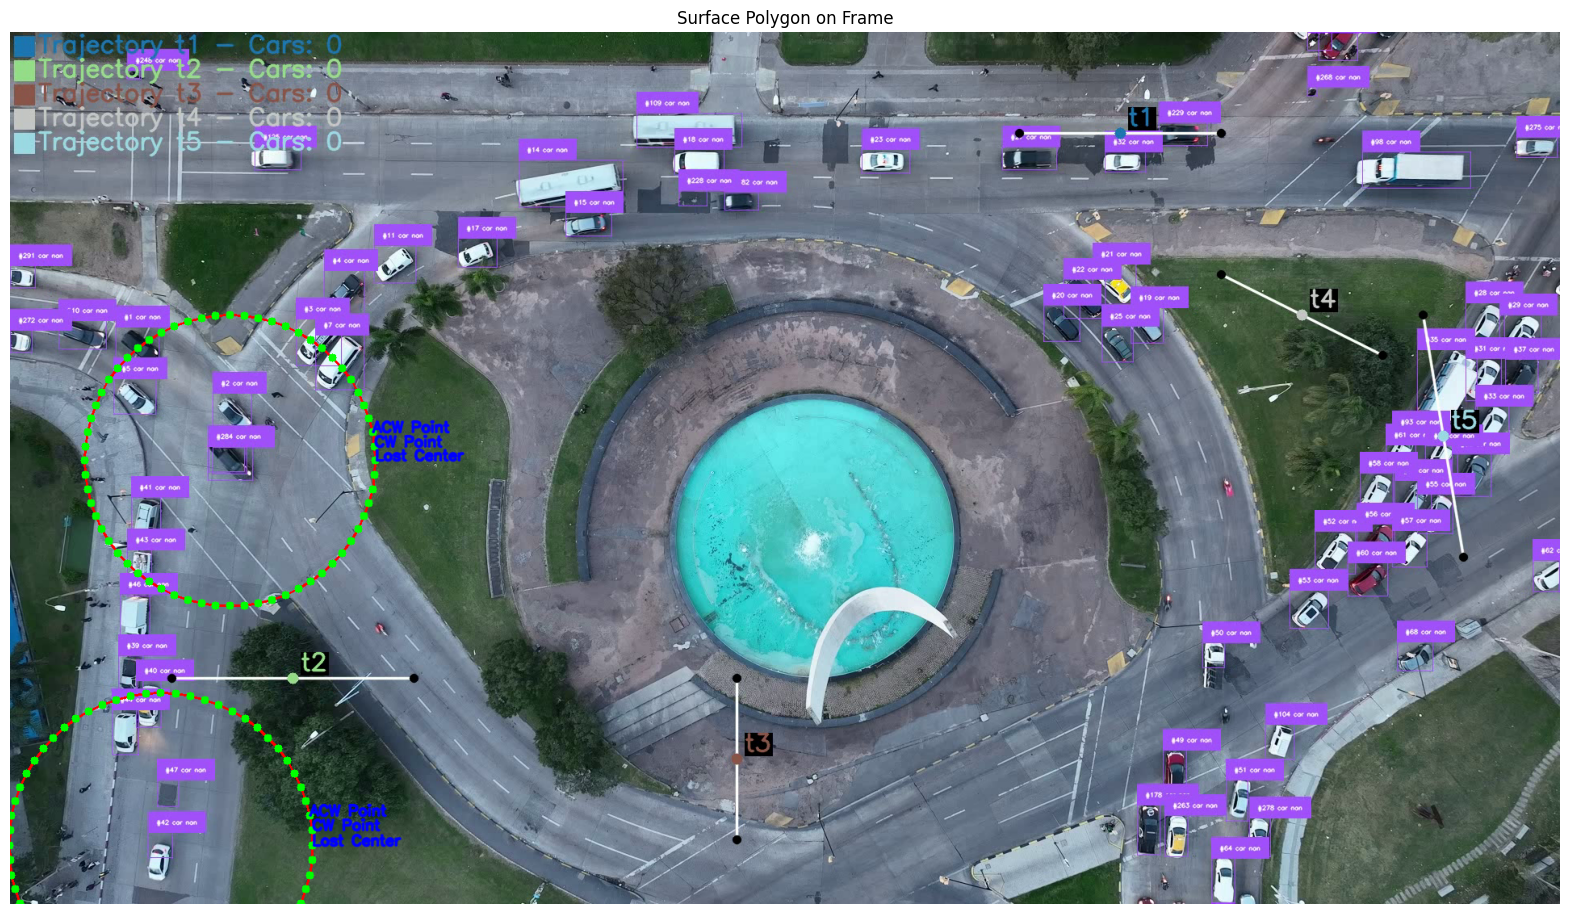

(array([0.45677279, 0.88958339]), 0.0)

In [11]:
df = pd.read_csv('df.csv')
video_path = 're_train\Test\BASE\RESIZED_DJI_20240604174215_0006_V_tracking_ByteTrack_TEST_2.mp4'
plot_search_surface(frame_num=74, #28 31 43 49 53 56 66 68 69 72 74 76 78
                    front_buffer=30, 
                    distance=50, 
                    frame_width=1920, 
                    frame_height=1080, 
                    df=df, 
                    back_buffer=5, 
                    video_path=video_path, 
                    figsize=(20,20),
                    angle=30,
                    use_circular_surface=True)



In [5]:
from tqdm import tqdm

#Reassing lost IDs
last_frame = df['frame'].max()
for frame_num in tqdm(range(last_frame + 1), desc='Reassigning lost IDs'): 
    lost_ids, created_ids = find_lost_and_created_tracker_ids(frame1_num=frame_num, front_buffer=30, back_buffer=30, distance=50, frame_width=1920, frame_height=1080, df_filled=df)

    for lost_id in lost_ids:
        try:    
            direction, speed = calculate_direction_and_speed(lost_id=lost_id, df_filled=df, frame_num=frame_num, buffer=30)
            df = reassign_lost_id(
                                            lost_id=lost_id,
                                            direction_vector=direction,
                                            speed=speed,
                                            buffer=90,
                                            df_filled=df,
                                            created_ids=created_ids,
                                            frame_num=frame_num,
                                            angle= 30
                                            )

        except Exception as e:
            print (e)

Reassigning lost IDs:  11%|█         | 36/322 [00:00<00:02, 142.11it/s]

Reassigned lost_id 16 to created_id 125 in frame 24.
Reassigned lost_id 26 to created_id 109 in frame 26.
Reassigned lost_id 24 to created_id 182 in frame 43.


Reassigning lost IDs:  20%|█▉        | 64/322 [00:00<00:02, 118.85it/s]

Reassigned lost_id 30 to created_id 209 in frame 49.
Reassigned lost_id 200 to created_id 248 in frame 53.
Reassigned lost_id 30 to created_id 229 in frame 56.
Reassigned lost_id 8 to created_id 253 in frame 66.
Reassigned lost_id 208 to created_id 263 in frame 68.
Reassigned lost_id 8 to created_id 265 in frame 69.


Reassigning lost IDs:  28%|██▊       | 89/322 [00:00<00:02, 103.76it/s]

Reassigned lost_id 257 to created_id 311 in frame 72.
Reassigned lost_id 273 to created_id 284 in frame 74.
Reassigned lost_id 200 to created_id 218 in frame 76.
Reassigned lost_id 268 to created_id 298 in frame 78.
Reassigned lost_id 257 to created_id 357 in frame 88.
Reassigned lost_id 51 to created_id 407 in frame 91.


Reassigning lost IDs:  37%|███▋      | 119/322 [00:00<00:01, 124.85it/s]

Reassigned lost_id 2 to created_id 337 in frame 92.
Reassigned lost_id 23 to created_id 332 in frame 99.
Reassigned lost_id 2 to created_id 358 in frame 100.
Reassigned lost_id 17 to created_id 431 in frame 110.
Reassigned lost_id 5 to created_id 414 in frame 118.


Reassigning lost IDs:  46%|████▌     | 148/322 [00:01<00:01, 120.91it/s]

Reassigned lost_id 17 to created_id 450 in frame 126.
Reassigned lost_id 17 to created_id 462 in frame 138.
Reassigned lost_id 17 to created_id 478 in frame 143.
Reassigned lost_id 443 to created_id 541 in frame 146.


Reassigning lost IDs:  54%|█████▍    | 175/322 [00:01<00:01, 112.61it/s]

Reassigned lost_id 26 to created_id 500 in frame 161.
Reassigned lost_id 1 to created_id 520 in frame 164.
Reassigned lost_id 482 to created_id 573 in frame 166.
Reassigned lost_id 526 to created_id 614 in frame 169.
Reassigned lost_id 391 to created_id 635 in frame 174.
Reassigned lost_id 443 to created_id 482 in frame 174.
Reassigned lost_id 273 to created_id 605 in frame 177.
Reassigned lost_id 27 to created_id 545 in frame 179.


Reassigning lost IDs:  64%|██████▎   | 205/322 [00:01<00:00, 126.31it/s]

Reassigned lost_id 443 to created_id 637 in frame 182.
Reassigned lost_id 30 to created_id 599 in frame 183.
Reassigned lost_id 18 to created_id 613 in frame 185.
Reassigned lost_id 2 to created_id 636 in frame 194.
Reassigned lost_id 443 to created_id 649 in frame 204.


Reassigning lost IDs:  72%|███████▏  | 232/322 [00:01<00:00, 124.53it/s]

Reassigned lost_id 443 to created_id 679 in frame 213.
Reassigned lost_id 665 to created_id 692 in frame 219.
Reassigned lost_id 443 to created_id 686 in frame 224.
Reassigned lost_id 32 to created_id 665 in frame 226.
Reassigned lost_id 691 to created_id 747 in frame 231.
Reassigned lost_id 272 to created_id 713 in frame 237.


Reassigning lost IDs:  80%|████████  | 258/322 [00:02<00:00, 120.23it/s]

Reassigned lost_id 50 to created_id 779 in frame 240.
Reassigned lost_id 526 to created_id 731 in frame 241.
Reassigned lost_id 59 to created_id 843 in frame 253.
Reassigned lost_id 2 to created_id 847 in frame 255.
Reassigned lost_id 526 to created_id 842 in frame 257.
Reassigned lost_id 291 to created_id 809 in frame 258.
Reassigned lost_id 23 to created_id 793 in frame 262.
Reassigned lost_id 50 to created_id 867 in frame 263.


Reassigning lost IDs:  88%|████████▊ | 283/322 [00:02<00:00, 104.58it/s]

Reassigned lost_id 691 to created_id 808 in frame 265.
Reassigned lost_id 786 to created_id 753 in frame 266.
Reassigned lost_id 802 to created_id 822 in frame 267.
Reassigned lost_id 208 to created_id 845 in frame 274.
Reassigned lost_id 750 to created_id 50 in frame 274.
Reassigned lost_id 802 to created_id 840 in frame 274.
Reassigned lost_id 473 to created_id 890 in frame 280.
Reassigned lost_id 59 to created_id 853 in frame 282.
Reassigned lost_id 802 to created_id 877 in frame 282.


Reassigning lost IDs:  96%|█████████▌| 308/322 [00:02<00:00, 103.15it/s]

Reassigned lost_id 98 to created_id 923 in frame 299.
Reassigned lost_id 497 to created_id 933 in frame 303.
Reassigned lost_id 30 to created_id 922 in frame 307.
Reassigned lost_id 58 to created_id 919 in frame 307.
Reassigned lost_id 58 to created_id 912 in frame 313.
Reassigned lost_id 467 to created_id 935 in frame 315.


Reassigning lost IDs: 100%|██████████| 322/322 [00:02<00:00, 110.70it/s]


#### **Usando superficie circular**

##### **Video nuevo (0001)**

In [79]:
df_0001 = pd.read_csv('df_0001_interpolated.csv')
video_path = 're_train\Test\Reassigning_IDs\RESIZED_DJI_20241003123313_0001_V_tracking_chequeo_manual_cono.mp4'

In [97]:
find_lost_and_created_tracker_ids(frame1_num=1173, 
                                    front_buffer=30, 
                                    back_buffer=5, 
                                    distance=50, 
                                    frame_width=1920, 
                                    frame_height=1080, 
                                    df_filled=df_0001)

([240], [264, 267, 268, 269])

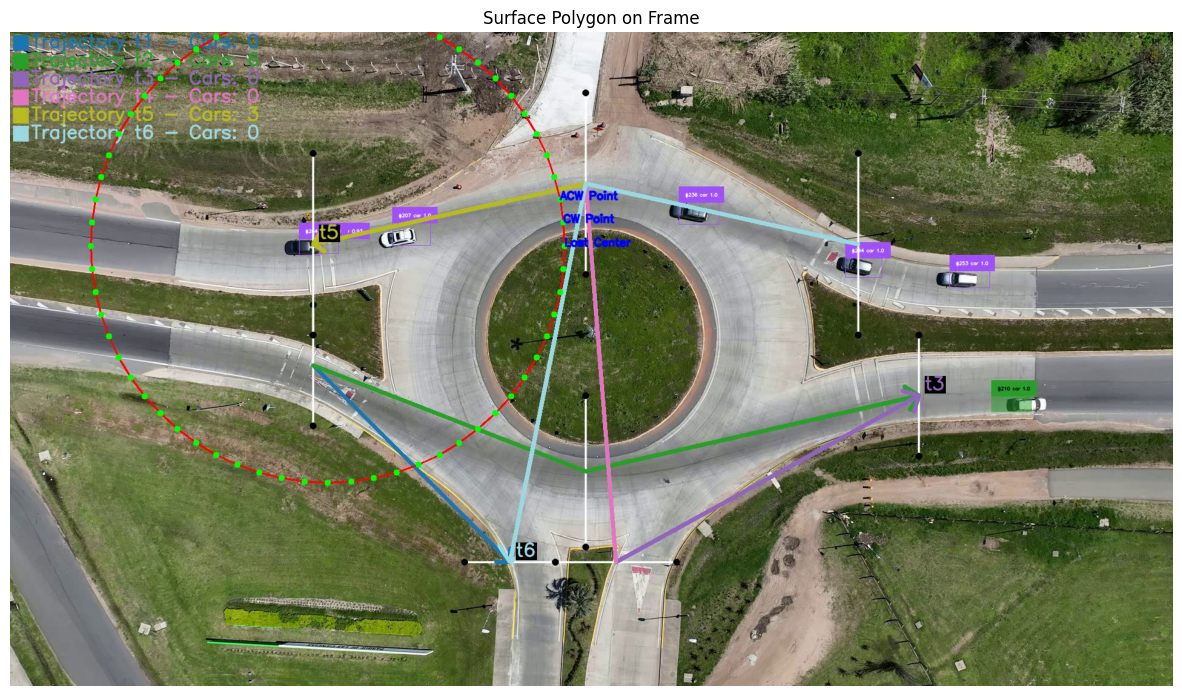

In [99]:
frames = list(range(1173,1174,1))
#frames = [1181, 1183, 1198, 1199]
#frames = [1198, 1199]
for frame in frames:

    plot_search_surface(frame_num=frame, #28 31 43 49 53 56 66 68 69 72 74 76 78
                        front_buffer=30, 
                        distance=50, 
                        frame_width=1920, 
                        frame_height=1080, 
                        df=df_0001, 
                        back_buffer=5, 
                        video_path=video_path, 
                        figsize=(15,15),
                        angle=30,
                        use_circular_surface=True)

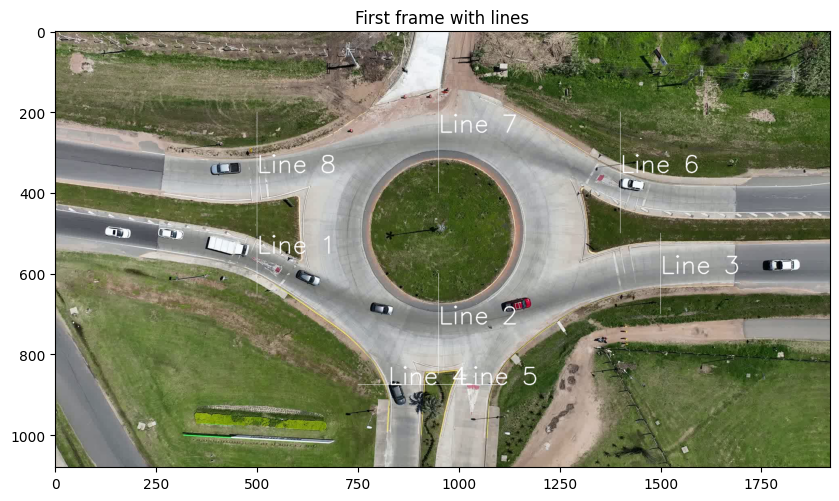

Using provided line points:
Coordinates for Line 1: (500,450) --> (500,650)
Coordinates for Line 2: (950,600) --> (950,850)
Coordinates for Line 3: (1500,500) --> (1500,700)
Coordinates for Line 4: (750,875) --> (900,875)
Coordinates for Line 5: (900,875) --> (1100,875)
Coordinates for Line 6: (1400,200) --> (1400,500)
Coordinates for Line 7: (950,100) --> (950,400)
Coordinates for Line 8: (500,200) --> (500,500)

Using provided trajectories:
Lines for Trajectory t1: [1, 4]
Lines for Trajectory t2: [1, 2, 3]
Lines for Trajectory t3: [5, 3]
Lines for Trajectory t4: [5, 7, 8]
Lines for Trajectory t5: [6, 7, 8]
Lines for Trajectory t6: [6, 7, 4]


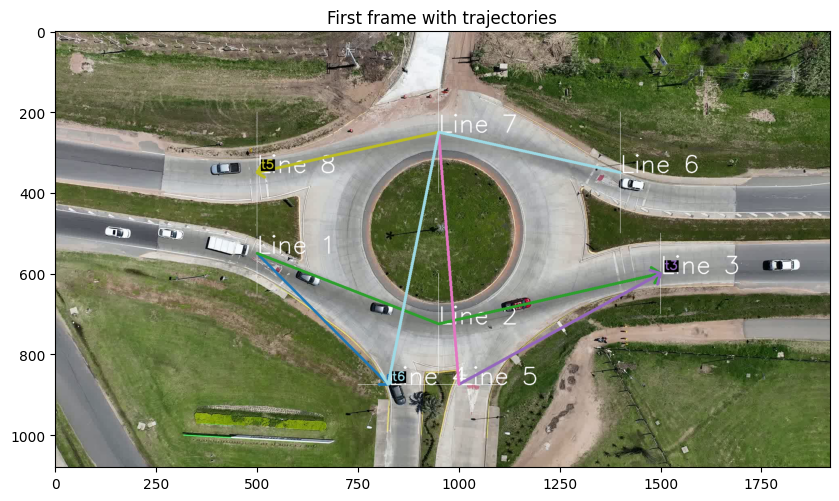

Reassigning lost IDs: 100%|██████████| 6858/6858 [00:17<00:00, 388.52it/s]


Insufficient detections for tracker ID 2545 within the buffer.
Insufficient detections for tracker ID 2546 within the buffer.
583 lost IDs were reassigned


Creating video: 100%|██████████| 6858/6858 [05:14<00:00, 21.80it/s]


Tracked video saved to ./re_train/Test/Reassigning_IDs/RESIZED_DJI_20241003123313_0001_V_tracking_chequeo_manual_circular.mp4

------------------------------ Trajectory t1 ------------------------------
Lines: [1, 4]   |   Total counted vehicles:  3   |   Counted vehicles IDs:  [1297, 562, 1015]

------------------------------ Trajectory t2 ------------------------------
Lines: [1, 2, 3]   |   Total counted vehicles:  28   |   Counted vehicles IDs:  [1152, 901, 1926, 650, 17, 18, 402, 1053, 1181, 1953, 425, 48, 1971, 2229, 65, 323, 1091, 1988, 2122, 205, 84, 982, 862, 614, 621, 2029, 627, 383]

------------------------------ Trajectory t3 ------------------------------
Lines: [5, 3]   |   Total counted vehicles:  0   |   Counted vehicles IDs:  []

------------------------------ Trajectory t4 ------------------------------
Lines: [5, 7, 8]   |   Total counted vehicles:  0   |   Counted vehicles IDs:  []

------------------------------ Trajectory t5 ------------------------------
Lines:

In [105]:
video_path = "./../../RESIZED_DJI_20241003123313_0001_V.mp4" # video nuevo 0001
output_folder = './re_train/Test/Reassigning_IDs/'
output_video_path = output_folder+video_path.split('/')[-1].replace('.mp4', '_tracking_chequeo_manual_circular.mp4')

lines_points = [
    (500, 450, 500, 650),    # Line 1
    (950, 600, 950, 850),    # Line 2
    (1500, 500, 1500, 700),  # Line 3
    (750, 875, 900, 875),    # Line 4
    (900, 875, 1100, 875), # Line 5
    (1400, 200, 1400, 500),  # Line 6
    (950, 100, 950, 400),    # Line 7
    (500, 200, 500, 500)     # Line 8
]

trajectories = [
    [1, 4],     # Trajectory t2
    [1, 2, 3],  # Trajectory t3
    [5, 3],     # Trajectory t5
    [5, 7, 8],  # Trajectory t6
    [6, 7, 8],  # Trajectory t8
    [6, 7, 4]    # Trajectory t9
]

tracks,df_0001_sin_reasignar = predict_and_track_on_video_df(video_path=video_path, output_video_path=output_video_path, df=df_0001, bbox_tracked='color',
                               bbox_untracked='box', annotate_untracked=True, classes=class_names, frame_step=1, json_dump=False,
                               use_circular_surface=True, lines_points=lines_points, trajectories=trajectories, reassign_ids=True)

##### **Video viejo (0009)**

In [50]:
df_0009 = pd.read_csv('df_0009.csv')

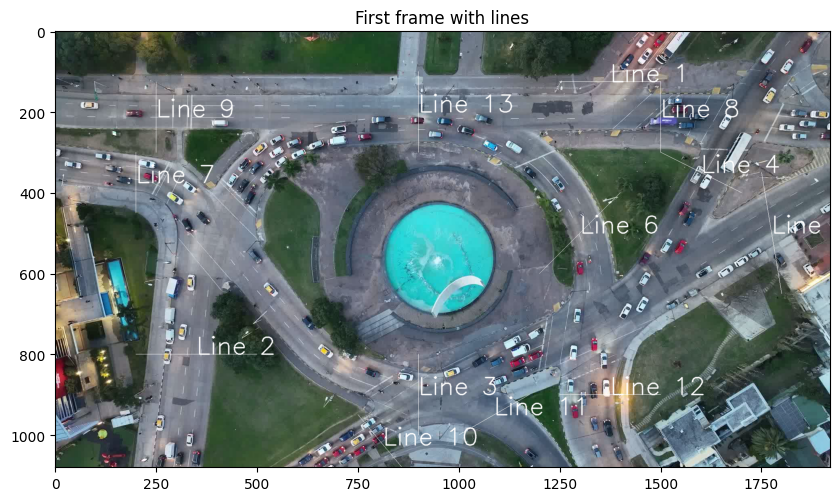

Using provided line points:
Coordinates for Line 1: (1250,125) --> (1500,125)
Coordinates for Line 2: (200,800) --> (500,800)
Coordinates for Line 3: (900,800) --> (900,1000)
Coordinates for Line 4: (1500,300) --> (1700,400)
Coordinates for Line 5: (1750,350) --> (1800,650)
Coordinates for Line 6: (1200,600) --> (1400,400)
Coordinates for Line 7: (200,300) --> (200,450)
Coordinates for Line 8: (1500,125) --> (1500,300)
Coordinates for Line 9: (250,125) --> (250,300)
Coordinates for Line 10: (750,950) --> (875,1100)
Coordinates for Line 11: (1000,1000) --> (1175,900)
Coordinates for Line 12: (1250,900) --> (1500,900)
Coordinates for Line 13: (900,100) --> (900,300)

Using provided trajectories:
Lines for Trajectory t1: [1, 2]
Lines for Trajectory t2: [8, 2]
Lines for Trajectory t3: [8, 9]
Lines for Trajectory t4: [1, 3, 11]
Lines for Trajectory t5: [10, 3, 4]
Lines for Trajectory t6: [10, 3, 5]
Lines for Trajectory t7: [10, 3, 6]
Lines for Trajectory t8: [10, 3, 11]
Lines for Trajectory

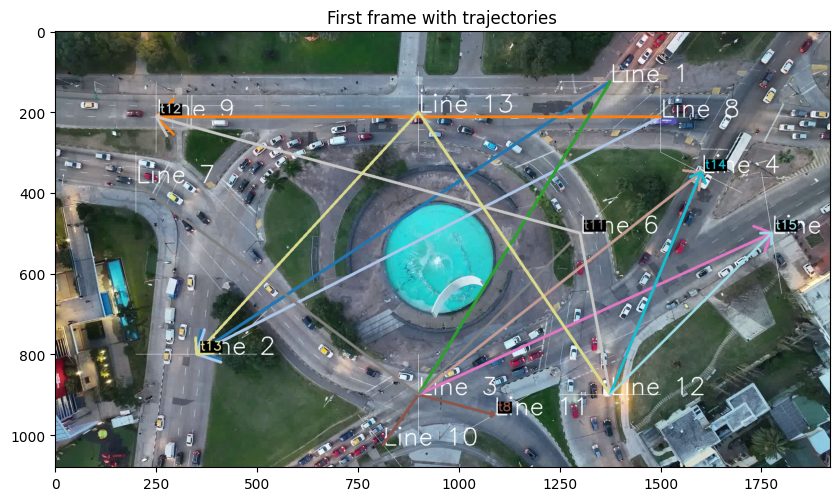

Reassigning lost IDs: 100%|██████████| 6854/6854 [01:48<00:00, 63.00it/s] 


802 lost IDs were reassigned


Creating video: 100%|██████████| 6854/6854 [12:03<00:00,  9.47it/s] 


Tracked video saved to ./re_train/Test/Reassigning_IDs/RESIZED_DJI_20240604175037_0009_V_tracking_chequeo_manual.mp4

------------------------------ Trajectory t1 ------------------------------
Lines: [1, 2]   |   Total counted vehicles:  22   |   Counted vehicles IDs:  [13571, 3462, 13062, 13852, 34, 39, 14131, 12481, 1859, 13637, 2502, 12371, 2772, 2138, 2915, 14062, 13423, 12784, 12914, 1651, 13170, 2806]

------------------------------ Trajectory t2 ------------------------------
Lines: [8, 2]   |   Total counted vehicles:  16   |   Counted vehicles IDs:  [16162, 4867, 5924, 16901, 15684, 7385, 5257, 6831, 4977, 5235, 16788, 53, 56, 57, 16988, 13663]

------------------------------ Trajectory t3 ------------------------------
Lines: [8, 9]   |   Total counted vehicles:  28   |   Counted vehicles IDs:  [4609, 16783, 5394, 10004, 5660, 7708, 5027, 17700, 4517, 38, 16293, 4012, 45, 44, 49, 4408, 9273, 4538, 16451, 5700, 7749, 5846, 6619, 6112, 17379, 10858, 17649, 6136]

------------

In [68]:
video_path = "./../../RESIZED_DJI_20240604175037_0009_V.mp4"
output_folder = './re_train/Test/Reassigning_IDs/'
output_video_path = output_folder+video_path.split('/')[-1].replace('.mp4', '_tracking_chequeo_manual.mp4')

lines_points = [(1250, 125, 1500, 125), (200, 800, 500, 800),  (900, 800, 900, 1000), (1500, 300, 1700, 400), (1750, 350, 1800, 650),
                (1200, 600, 1400, 400), (200, 300, 200, 450), (1500, 125, 1500, 300), (250, 125, 250, 300), (750, 950, 875, 1100), (1000, 1000, 1175, 900),
                (1250, 900, 1500, 900), (900, 100, 900, 300)]

trajectories = [[1,2],[8,2],[8,9],[1,3,11],[10,3,4],[10,3,5],[10,3,6],[10,3,11],[7,3,4],[7,3,5], [7,3,6], [12,6,9], [12,13,2], [12,4], [12,5]]

tracks,df_0009_filled = predict_and_track_on_video_df(video_path=video_path, output_video_path=output_video_path, df=df_0009, bbox_tracked='color',
                               bbox_untracked='box', annotate_untracked=True, classes=class_names, frame_step=1, json_dump=False,
                               use_circular_surface=False, lines_points=lines_points, trajectories=trajectories)

In [6]:
video_path = './re_train/Test/Reassigning_IDs/RESIZED_DJI_20240604175037_0009_V_tracking_chequeo_manual_cono.mp4' # video largo desde arriba RESIZED
start_time = [2, 0]  # Start at 0 minute 0 seconds
end_time = [2, 10]    # End at 0 minutes 60 seconds
output_folder = './re_train/Test/Reassigning_IDs/'

cropped_video_path = crop_video_by_time(video_path, start_time, end_time, output_folder)

Cropping Video: 100%|██████████| 290/290 [00:04<00:00, 65.85frame/s]

Video successfully cropped and saved at: ./re_train/Test/Reassigning_IDs/RESIZED_DJI_20240604175037_0009_V_tracking_chequeo_manual_cono_cropped.mp4


In [5]:
df_0001 = pd.read_csv('df_0001.csv')

In [9]:
for tracker_id, group in df_0001.groupby('tracker_id'):
    if tracker_id == 1:
        print (tracker_id)
        display(group.head())

1


frame  tracker_id  class_id  confidence       x_min       y_min  \
0       0           1         0    0.999893  384.808258  322.063965   
9       1           1         0    0.999872  381.251114  322.337814   
18      2           1         0    0.999880  376.716634  322.589355   
27      3           1         0    0.999878  372.853966  322.778336   
36      4           1         0    0.999873  369.498004  323.135303   

         x_max       y_max  
0   461.411316  357.437653  
9   457.283783  358.055679  
18  452.722219  358.305857  
27  448.993973  358.466995  
36  445.251465  358.578461

In [10]:
df_int = interpolate_missing_detections(df_0001)

Interpolating detections between frames: 100%|██████████| 315/315 [00:00<00:00, 702.45it/s]


In [ ]:
# Read the image
img_path = '/content/drive/MyDrive/Conteo de Maniobras/Models/Datasets/roundabouts/imgs/val/00001_frame000310_original.jpg'
img = cv2.imread(img_path)
img = get_first_frame()

# Make predictions
outputs = predictor(img)    # Read the image
detections = sv.Detections.from_detectron2(outputs)
tracker = sv.ByteTrack()
tracker.reset()
detections = tracker.update_with_detections(detections)
detections

In [3]:
video_path = "H:\My Drive\Conteo de Maniobras\RESIZED_DJI_20241003123313_0001_V.mp4"
output_folder = '.'
crop_video_by_time(video_path=video_path,start_time=[0,0], end_time=[0,2], output_folder=output_folder)



NameError: name 'crop_video_by_time' is not defined